In [1]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [2]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp)
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

In [3]:

df_target= df_all_sorted[
    ((df_all_sorted['EVENT'] == 3109 ) | (df_all_sorted['EVENT'] == 9705 )) &
    ((df_all_sorted['MCRUN'] == 266033) | (df_all_sorted['MCRUN'] == 263369) )
]
print(df_target[["TIME_NS", "TIME_S","TIME_ABS"]])

         TIME_NS  TIME_S    TIME_ABS
4462   599190677       1  1599190677
4463   599190850       1  1599190850
4464   599190978       1  1599190978
4465   599191074       1  1599191074
4466   599191383       1  1599191383
4467   599191442       1  1599191442
4468   599191467       1  1599191467
4469   599191880       1  1599191880
4470   599191911       1  1599191911
14810  466290070       5  5466290070
14811  466290239       5  5466290239
14812  466290420       5  5466290420
14813  466290499       5  5466290499
14814  466290869       5  5466290869
14815  466290902       5  5466290902
14816  466290908       5  5466290908
14817  466291393       5  5466291393
14818  466291410       5  5466291410


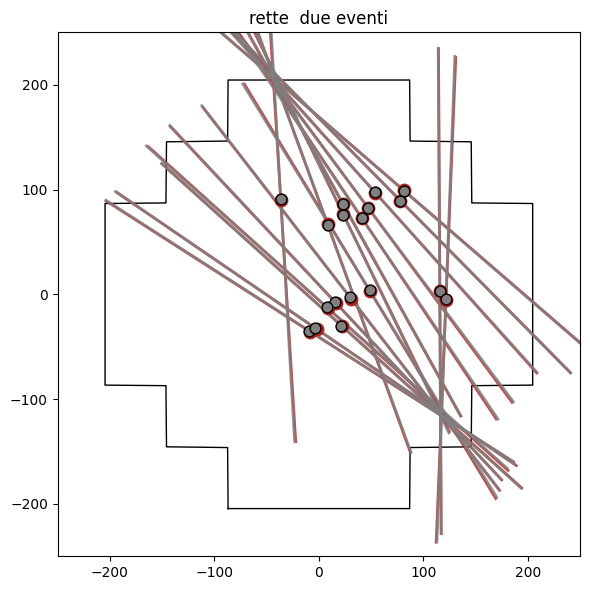

HG rette: 18
LG rette: 18
{'p0': array([22.99149501, 86.22200894]), 'd': array([-0.48662229,  0.87361247]), 'tel': 2}


In [4]:

xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T

x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

rette_hg = []
rette_lg = []

# ============================================================
#   calcolo, sigma clip, istogrammi, salvataggio rette

for iv in range(len(df_target)):

    itel = df_target["TEL_ID"].iloc[iv]
    hgev = np.array(df_target['HG'])[iv]
    lgev = np.array(df_target['LG'])[iv]
    ttpev = np.array(df_target['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # --------------------------
    # SIGMA-CLIPPING
    
    xx = x_pix[pxmask].flatten()
    yy = y_pix[pxmask].flatten()
    w_hg = hgev[pxmask].flatten()
    w_lg = lgev[pxmask].flatten()

    mx0 = np.average(xx, weights=w_hg)
    my0 = np.average(yy, weights=w_hg)

    r = np.sqrt((xx - mx0)**2 + (yy - my0)**2)

    r_clip, low, high = sc.sigmaclip(r, low=3.0, high=3.0)
    keep = (r >= low) & (r <= high)

    xx_sc = xx[keep]
    yy_sc = yy[keep]
    w_hg_sc = w_hg[keep]
    w_lg_sc = w_lg[keep]
    # --------------------------

    # ---------- centroidi ----------
    meanx_hg = np.average(xx_sc, weights=w_hg_sc)
    meany_hg = np.average(yy_sc, weights=w_hg_sc)

    meanx_lg = np.average(xx_sc, weights=w_lg_sc)
    meany_lg = np.average(yy_sc, weights=w_lg_sc)

    # ---------- covarianze ----------
    cov_hg = np.cov([xx_sc, yy_sc], aweights=w_hg_sc)
    cov_lg = np.cov([xx_sc, yy_sc], aweights=w_lg_sc)

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salvo le rette ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })
# ============================================================
#   tutte le rette insieme

fig, ax = plt.subplots(figsize=(6, 6))
# footprint camera 
ax.plot(xfp, yfp, 'k-', linewidth=1)

# calcolo lunghezza estetica delle rette
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

# centroidi e rette HG
for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide HG (punto rosso grande)
    ax.scatter(p0[0], p0[1], s=80, color="firebrick", zorder=5)

    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="firebrick", linewidth=2, alpha=0.8)

#  centroidi e rette LG 
for r in rette_lg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide LG (punto grigio più piccolo con bordo nero)
    ax.scatter(p0[0], p0[1], s=60, color="grey", edgecolor="black", zorder=5)

    # retta lunga LG (grey)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="grey", linewidth=2, alpha=0.8)

ax.set_title("rette  due eventi")
ax.set_xlim(-250,250 )
ax.set_ylim(-250,250)

plt.tight_layout()
plt.show()

print("HG rette:", len(rette_hg))
print("LG rette:", len(rette_lg))
print(rette_hg[0])


In [5]:
def intersection(p1, d1, p2, d2):
    """
    p1, p2 = centroidi
    d1, d2 = direzioni 
    """
    A = np.array([d1, -d2]).T
    b = p2 - p1

    # determinante per capire se sono parallele
    det = np.linalg.det(A)
    if abs(det) < 1e-6:
        return None  
    # risolvi i parametri t
    t = np.linalg.solve(A, b)[0]

    # punto di intersezione
    return p1 + t * d1
# ####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE HG
# ####################################################
N = len(rette_hg)
inters_hg = []

for i in range(N):
    p1 = rette_hg[i]["p0"]
    d1 = rette_hg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_hg[j]["p0"]
        d2 = rette_hg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_hg.append(P)

inters_hg = np.array(inters_hg)
v_hg_nf = inters_hg.copy()   


# #####################################################
# INTERSEZIONI TRA TUTTE LE COPPIE DI RETTE LG
# ####################################################à
N = len(rette_lg)
inters_lg = []

for i in range(N):
    p1 = rette_lg[i]["p0"]
    d1 = rette_lg[i]["d"]
    for j in range(i+1, N):
        p2 = rette_lg[j]["p0"]
        d2 = rette_lg[j]["d"]
        P = intersection(p1, d1, p2, d2)
        if P is not None:
            inters_lg.append(P)

inters_lg = np.array(inters_lg)
v_lg_nf = inters_lg.copy()  
#####Filtro i punti troppo lontani (grezzo)###############################################
v_hg= np.array([p for p in v_hg_nf if  all(-1000 <= coord <= 1000 for coord in p)])
v_lg= np.array([p for p in v_lg_nf if  all(-1000 <= coord <= 1000 for coord in p)])



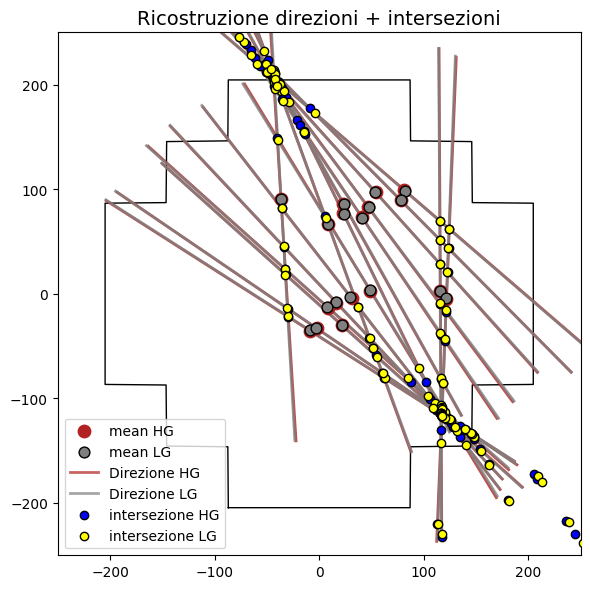

In [6]:
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.4* diag
fig, ax = plt.subplots(figsize=(6, 6))
# footprint camera 
ax.plot(xfp, yfp, 'k-', linewidth=1)

# calcolo lunghezza estetica delle rette
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag
centro_hg=np.mean(v_hg,axis=0)
centro_lg=np.mean(v_lg,axis=0)

median_hg=np.median(v_hg,axis=0)
median_lg=np.median(v_lg,axis=0)
# centroidi e rette HG
for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide HG (punto rosso grande)
    ax.scatter(p0[0], p0[1], s=80, color="firebrick", zorder=5)

    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="firebrick", linewidth=2, alpha=0.8)

#  centroidi e rette LG 
for r in rette_lg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide LG (punto grigio più piccolo con bordo nero)
    ax.scatter(p0[0], p0[1], s=60, color="grey", edgecolor="black", zorder=5)

    # retta lunga LG (grey)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="grey", linewidth=2, alpha=0.8)

ax.set_title("rette  due eventi")
ax.set_xlim(-250,250 )
ax.set_ylim(-250,250)


ax.scatter(v_hg[:,0], v_hg[:,1], marker="o",c="blue",edgecolor="black",zorder=5)
ax.scatter(v_lg[:,0], v_lg[:,1], marker="o",c="yellow",edgecolor="black",zorder=5)
ax.set_aspect('equal', 'box')
ax.grid(False)
ax.set_title("Ricostruzione direzioni + intersezioni", fontsize=14)
plt.tight_layout()



ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
'''
ax.scatter(centro_lg[0], centro_lg[1],zorder=5, 
                    color='cyan', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni LG')
ax.scatter(median_lg[0], median_lg[1], 
                    color='cyan', edgecolor='black',zorder=5,
                    s=120, marker='*', label='Mediana della intersezioni LG')

ax.scatter(centro_hg[0], centro_hg[1],zorder=5, 
                    color='red', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni HG')
ax.scatter(median_hg[0], median_hg[1], 
                    color='red', edgecolor='black',zorder=5,
                    s=120, marker='*', label='Mediana della intersezioni HG')
'''
 #dummy legends
ax.scatter([], [], color='firebrick', s=80, label="mean HG")
ax.scatter([], [], color='grey', s=60, edgecolor='black', label="mean LG")
ax.plot([], [], color='firebrick', linewidth=2, alpha=0.7, label="Direzione HG")
ax.plot([], [], color='grey', linewidth=2, alpha=0.7, label="Direzione LG")
ax.scatter([], [], c="blue", edgecolor="black",label="intersezione HG")
ax.scatter([], [], c="yellow", edgecolor="black",label="intersezione LG")
ax.legend(loc="lower left")



plt.show()




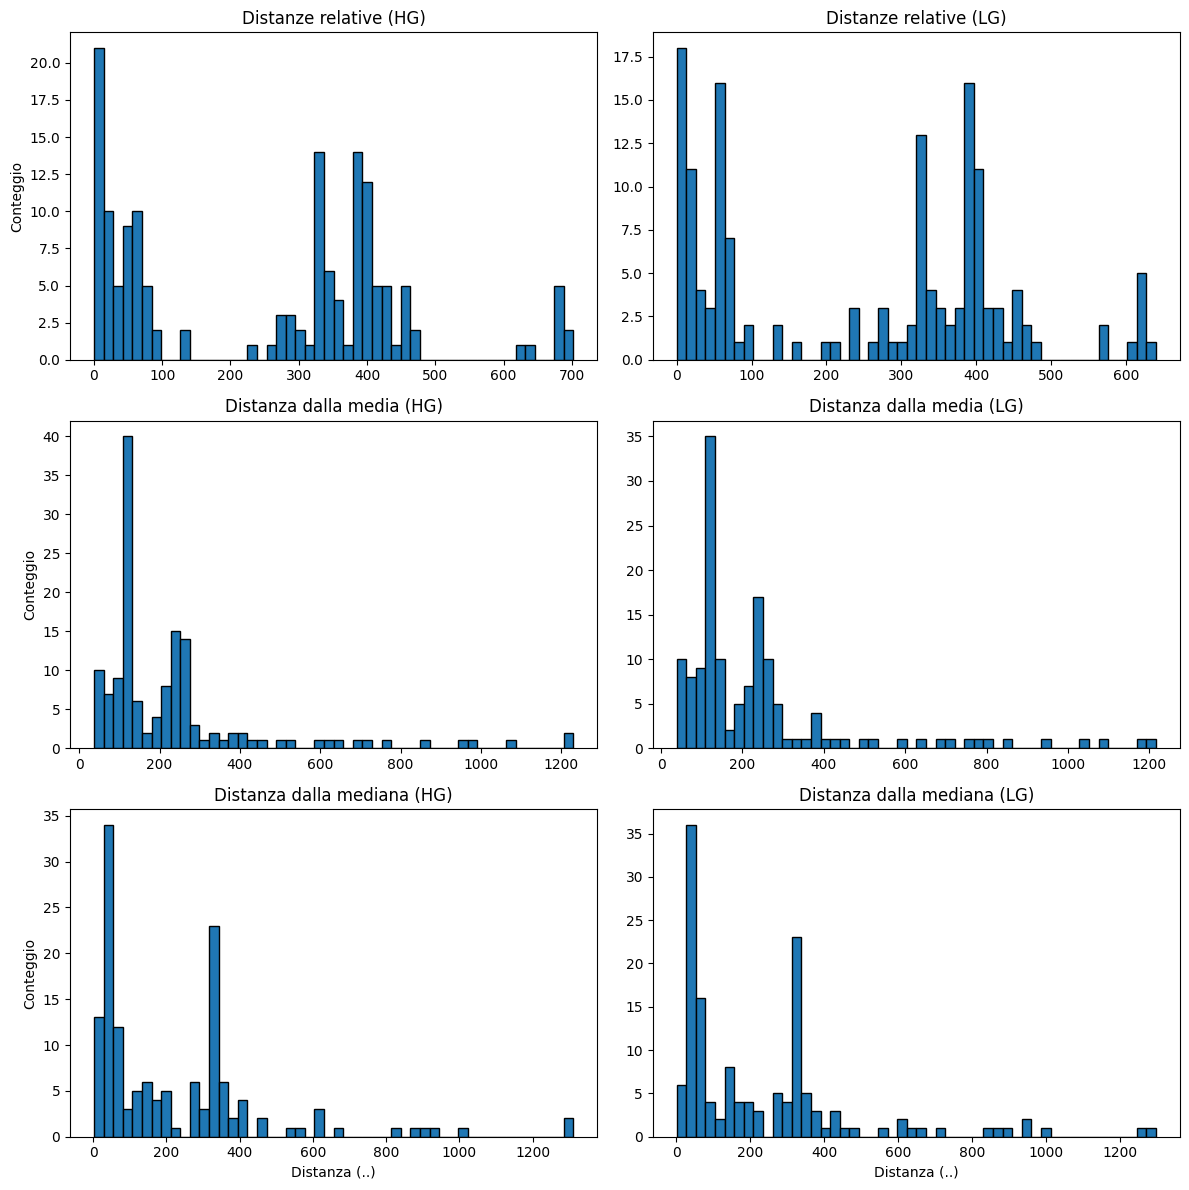

In [7]:
dists_hg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_hg[i] - v_hg[j])
        dists_hg.append(dij)
dists_hg = np.array(dists_hg)

dists_lg = []
for i in range(N):
    for j in range(i+1, N):
        dij = np.linalg.norm(v_lg[i] - v_lg[j])
        dists_lg.append(dij)
dists_lg = np.array(dists_lg)
centro_hg=np.mean(v_hg,axis=0)
centro_lg=np.mean(v_lg,axis=0)

median_hg=np.median(v_hg,axis=0)
median_lg=np.median(v_lg,axis=0)
#distanza euclidea punto-punto
dists_center_lg = np.linalg.norm(v_lg - centro_lg, axis=1)
dists_median_lg = np.linalg.norm(v_lg - median_lg, axis=1)

dists_center_hg = np.linalg.norm(v_hg - centro_hg, axis=1)
dists_median_hg = np.linalg.norm(v_hg - median_hg, axis=1)
#distribuzione relative tra le intersezioni per riuscire a dividere baricentro e media

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# -------------------- HG --------------------
#  distanze tra coppie
axes[0,0].hist(dists_hg, bins=50, edgecolor='black')
axes[0,0].set_title("Distanze relative (HG)")
axes[0,0].set_ylabel("Conteggio")

#  distanze dal baricentro
axes[1,0].hist(dists_center_hg, bins=50, edgecolor='black')
axes[1,0].set_title("Distanza dalla media (HG)")
axes[1,0].set_ylabel("Conteggio")

#  distanze dalla mediana
axes[2,0].hist(dists_median_hg, bins=50, edgecolor='black')
axes[2,0].set_title("Distanza dalla mediana (HG)")
axes[2,0].set_xlabel("Distanza (..)")
axes[2,0].set_ylabel("Conteggio")

# -------------------- LG --------------------
#  distanze tra coppie
axes[0,1].hist(dists_lg, bins=50, edgecolor='black')
axes[0,1].set_title("Distanze relative (LG)")

#  distanze dal baricentro
axes[1,1].hist(dists_center_lg, bins=50, edgecolor='black')
axes[1,1].set_title("Distanza dalla media (LG)")

#  distanze dalla mediana
axes[2,1].hist(dists_median_lg, bins=50, edgecolor='black')
axes[2,1].set_title("Distanza dalla mediana (LG)")
axes[2,1].set_xlabel("Distanza (..)")

plt.tight_layout()
plt.show()


Text(22.998159743311106, 0.5, 'Y')

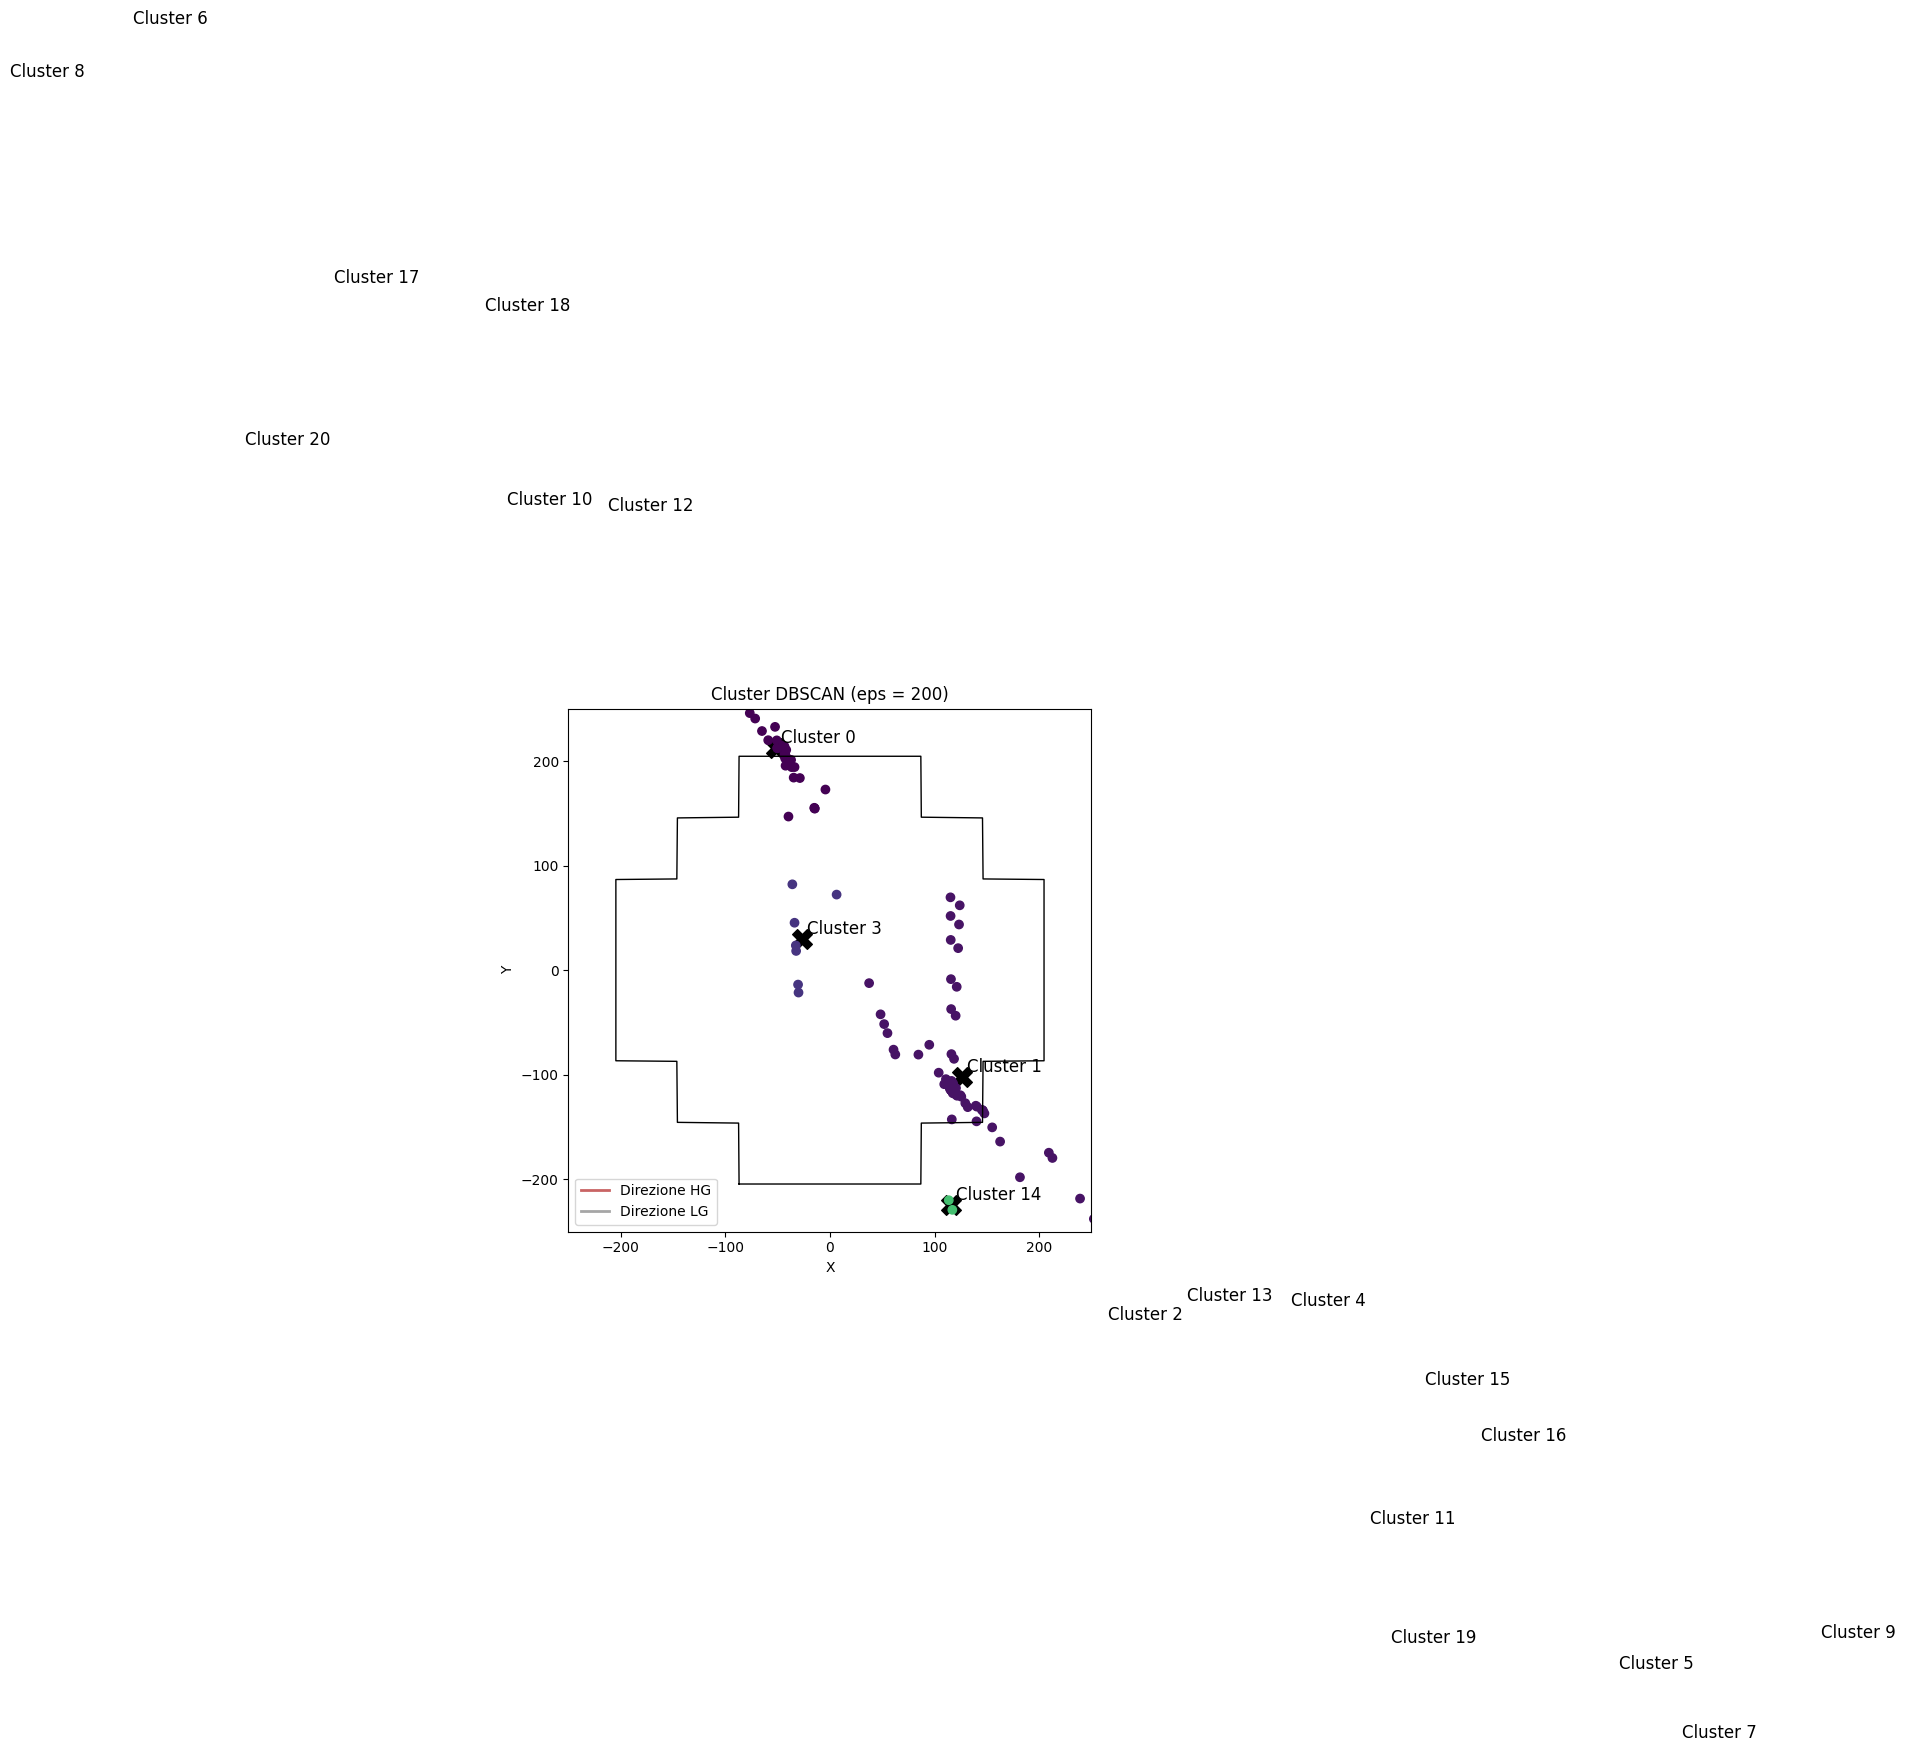

In [ ]:
###PROVA 1= seleziono i punti più vicini di 200

from sklearn.cluster import DBSCAN


# v_lg: array di punti shape (N, 2)

# 1) clustering DBSCAN con raggio 200
db = DBSCAN(eps=50, min_samples=1).fit(v_lg)

# 2) etichette dei cluster
labels = db.labels_

# 3) calcolo dei baricentri di ogni cluster
baricentri = []
for lab in np.unique(labels):
    punti_cluster = v_lg[labels == lab]
    baricentro = punti_cluster.mean(axis=0)
    baricentri.append(baricentro)
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(xfp, yfp, 'k-', linewidth=1)

ax.set_aspect('equal', 'box')
ax.grid(False)
ax.set_title("Ricostruzione direzioni + intersezioni", fontsize=14)
plt.tight_layout()

ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
'''
ax.scatter(centro_lg[0], centro_lg[1],zorder=5, 
                    color='cyan', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni LG')
ax.scatter(median_lg[0], median_lg[1], 
                    color='cyan', edgecolor='black',zorder=5,
                    s=120, marker='*', label='Mediana della intersezioni LG')

ax.scatter(centro_hg[0], centro_hg[1],zorder=5, 
                    color='red', edgecolor='black',
                    s=120, marker='o', label='Media delle intersezioni HG')
ax.scatter(median_hg[0], median_hg[1], 
                    color='red', edgecolor='black',zorder=5,
                    s=120, marker='*', label='Mediana della intersezioni HG')
'''
 #dummy legends

ax.plot([], [], color='firebrick', linewidth=2, alpha=0.7, label="Direzione HG")
ax.plot([], [], color='grey', linewidth=2, alpha=0.7, label="Direzione LG")

ax.legend(loc="lower left")
cluster_ids = np.unique(labels)

for cid, barc in zip(cluster_ids, baricentri):
    ax.scatter(barc[0], barc[1], c='black', s=200, marker='X')
    ax.text(barc[0] + 5, barc[1] + 5, f"Cluster {cid}", fontsize=12)
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
plt.xlim(-250,250)

ax.scatter(v_lg[:, 0], v_lg[:, 1], c=labels)
plt.title("Cluster DBSCAN (eps = 200)")
plt.xlabel("X")
plt.ylabel("Y")
#plt.show()

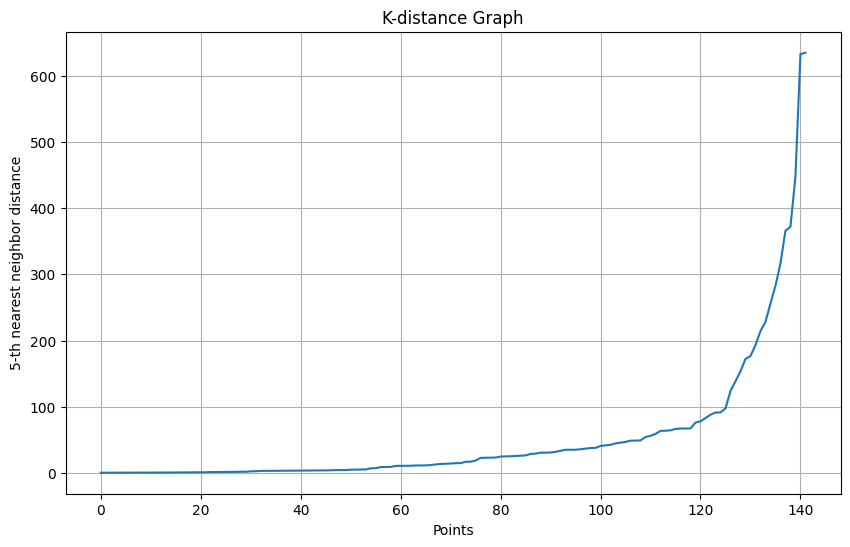

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.grid()
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(v_hg, k=5)
#per sciegliere il punto sul gomito===> intorno a 100 (anche da istogrammi)

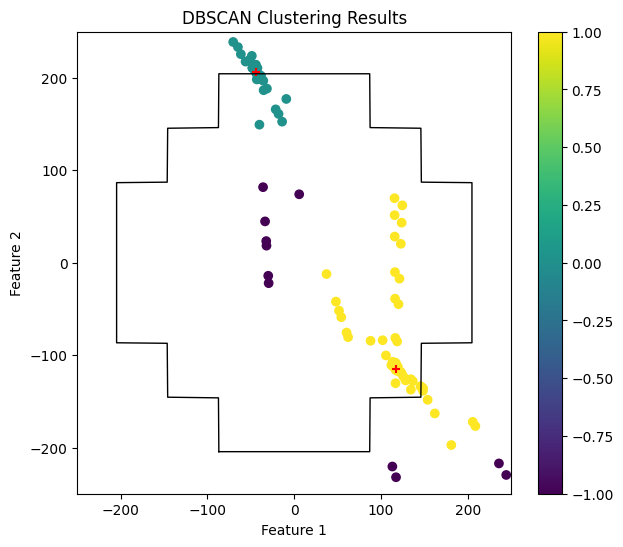

In [ ]:
# Perform DBSCAN clustering
epsilon = 50  # Chosen based on k-distance graph
min_samples = 6  # 2 * num_features (2D data)
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(v_hg)
#suddivido i punti in base al cluster
cluster0 = v_hg[clusters == 0]
cluster1 = v_hg[clusters == 1]
#mi calcolo la mediana dei punti del cluster 0 o 1
centro0 =np.median(cluster0,axis=0)
centro1=np.median(cluster1,axis=0)
plt.figure(figsize=(7, 6))
plt.plot(xfp, yfp, 'k-', linewidth=1)
scatter = plt.scatter(v_hg[:, 0], v_hg[:, 1], c=clusters, cmap='viridis')
plt.scatter(centro0[0],centro0[ 1], marker='+',c='red')
plt.scatter(centro1[0],centro1[ 1], marker='+',c='red')

plt.colorbar(scatter)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(-250,250)
plt.ylim(-250,250)
plt.show()

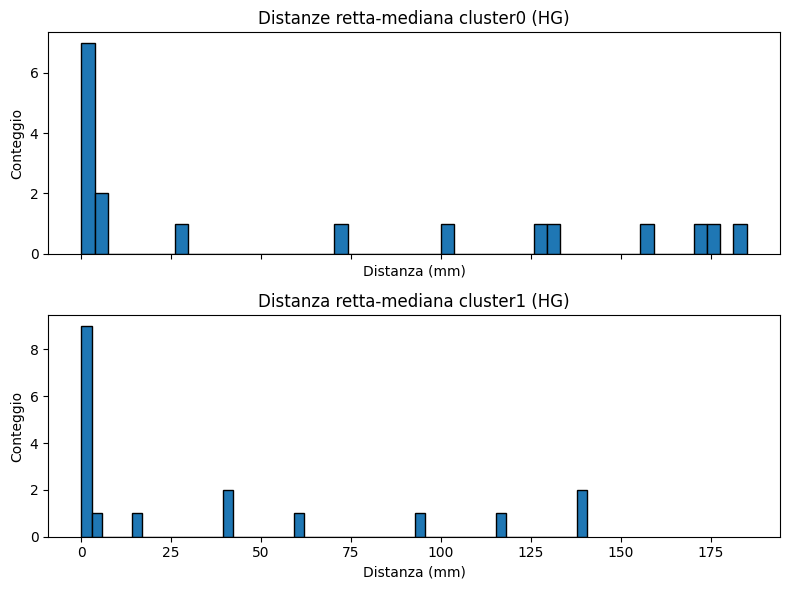

In [ ]:
#per ora solo rette hg e utilizzo mediana
r_median1 = []
r_median0=[]

for r in rette_hg:

    p0 = r["p0"]
    d  = r["d"]  
    # normalizzazione
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        continue
    d_unit = d / norm_d

    # vettore da p0 al punto P
    v = centro0 - p0
    u = centro1 - p0
    # distanza punto–retta
    dist0 = abs(v[0] * d_unit[1] - v[1] * d_unit[0])
    dist1=abs(u[0] * d_unit[1] - u[1] * d_unit[0])

    r_median1.append(dist0)
    r_median0.append(dist1)
    # filtro 
    if dist0 < 25:
        r["event"]=0

    if dist1 < 25:
        r["event"]=1
r_median1 = np.array(r_median1)
r_median0= np.array(r_median0)
'''
r_mean_lg = []
r_median_lg=[]
for r in rette_lg:

    p0 = r["p0"]
    d  = r["d"]  

    # normalizzazione
    norm_d = np.linalg.norm(d)
    if norm_d == 0:
        continue
    d_unit = d / norm_d

    # vettore da p0 al punto P
    v = centro_hg - p0
    u = median_hg - p0
    # distanza punto–retta
    dist_mean = abs(v[0] * d_unit[1] - v[1] * d_unit[0])
    dist_median=abs(u[0] * d_unit[1] - u[1] * d_unit[0])

    r_mean_lg.append(dist_mean)
    r_median_lg.append(dist_median)
r_mean_lg = np.array(r_mean_lg)
r_median_lg= np.array(r_median_lg)
'''
# -----------------------------
# Istogramma
# -----------------------------
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex='col')

# -------------------- HG --------------------
#  distanze tra coppie
axes[0].hist(r_median1, bins=50, edgecolor='black')
axes[0].set_title("Distanze retta-mediana cluster0 (HG)")
axes[0].set_ylabel("Conteggio")
axes[0].set_xlabel("Distanza (mm)")

#  distanze dal baricentro
axes[1].hist(r_median0, bins=50, edgecolor='black')
axes[1].set_title("Distanza retta-mediana cluster1 (HG)")
axes[1].set_ylabel("Conteggio")
axes[1].set_xlabel("Distanza (mm)")



# -------------------- LG --------------------
#  distanze tra coppie
#axes[0,1].hist(r_mean_lg, bins=50, edgecolor='black')
#axes[0,1].set_title("Distanze retta-media (LG)")

#  distanze dal baricentro
#axes[1,1].hist(r_median_lg, bins=50, edgecolor='black')
#axes[1,1].set_title("Distanza retta-mediana (LG)")
#axes[1,1].set_xlabel("Distanza (mm)")

plt.tight_layout()
plt.show()

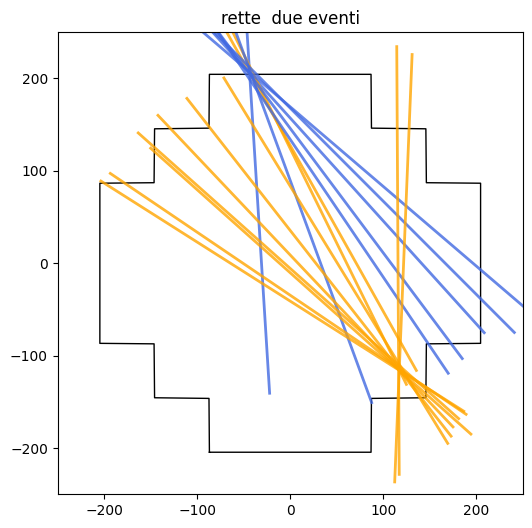

In [12]:
colori = {0: "royalblue", 1: "orange"}   # colori per i due eventi
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(xfp, yfp, 'k-', linewidth=1)

for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]
    col=colori[r["event"]]
    
    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color=col, linewidth=2, alpha=0.8)


ax.set_title("rette  due eventi")
ax.set_xlim(-250,250 )
ax.set_ylim(-250,250)
plt.show()
